<a href="https://colab.research.google.com/github/samityasir2005/ufc_predictor_ML/blob/main/ufc_pytorch_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kagglehub pandas numpy torch matplotlib seaborn scikit-learn

In [2]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.0+cu126
CUDA available: True


In [3]:
path = kagglehub.dataset_download("mdabbert/ultimate-ufc-dataset")
print("Dataset path:", path)

100%|██████████| 756k/756k [00:00<00:00, 1.58MB/s]

Extracting files...
Dataset path: /root/.cache/kagglehub/datasets/mdabbert/ultimate-ufc-dataset/versions/177


In [4]:
# Load dataset and remove outcome-related columns to prevent data leakage
df = pd.read_csv(os.path.join(path, 'ufc-master.csv'))
print(f"Original shape: {df.shape}")
columns_to_remove = ['RedOdds', 'BlueOdds', 'RedDecOdds', 'BlueDecOdds',
                     'RSubOdds', 'BSubOdds', 'RKOOdds', 'BKOOdds',
                     'RedExpectedValue', 'BlueExpectedValue', 'Finish',
                     'FinishDetails', 'FinishRound', 'FinishRoundTime',
                     'TotalFightTimeSecs', 'BetterRank']
df = df.drop(columns=[col for col in columns_to_remove if col in df.columns])
print(f"Cleaned shape: {df.shape}")

Original shape: (6528, 118)
Cleaned shape: (6528, 102)


In [5]:
# Create features
def create_features(df):
    features = pd.DataFrame()

    # Physical attributes
    features['height_diff'] = df['RedHeightCms'] - df['BlueHeightCms']
    features['reach_diff'] = df['RedReachCms'] - df['BlueReachCms']
    features['age_diff'] = df['RedAge'] - df['BlueAge']

    # Win/loss record
    features['wins_diff'] = df['RedWins'] - df['BlueWins']
    features['losses_diff'] = df['RedLosses'] - df['BlueLosses']

    # Win rates
    red_fights = df['RedWins'] + df['RedLosses'] + df['RedDraws']
    blue_fights = df['BlueWins'] + df['BlueLosses'] + df['BlueDraws']
    features['win_rate_diff'] = (df['RedWins'] / red_fights.replace(0, 1)) - (df['BlueWins'] / blue_fights.replace(0, 1))

    # Momentum
    features['win_streak_diff'] = df['RedCurrentWinStreak'] - df['BlueCurrentWinStreak']
    features['momentum_diff'] = (df['RedCurrentWinStreak'] - df['RedCurrentLoseStreak']) - (df['BlueCurrentWinStreak'] - df['BlueCurrentLoseStreak'])

    # Fighting stats
    features['sig_str_landed_diff'] = df['RedAvgSigStrLanded'] - df['BlueAvgSigStrLanded']
    features['sig_str_pct_diff'] = df['RedAvgSigStrPct'] - df['BlueAvgSigStrPct']
    features['td_landed_diff'] = df['RedAvgTDLanded'] - df['BlueAvgTDLanded']
    features['td_pct_diff'] = df['RedAvgTDPct'] - df['BlueAvgTDPct']
    features['sub_att_diff'] = df['RedAvgSubAtt'] - df['BlueAvgSubAtt']

    # Finish rates
    features['ko_rate_diff'] = (df['RedWinsByKO'] / df['RedWins'].replace(0, 1)) - (df['BlueWinsByKO'] / df['BlueWins'].replace(0, 1))
    features['sub_rate_diff'] = (df['RedWinsBySubmission'] / df['RedWins'].replace(0, 1)) - (df['BlueWinsBySubmission'] / df['BlueWins'].replace(0, 1))

    # Experience
    features['experience_diff'] = red_fights - blue_fights
    features['total_rounds_diff'] = df['RedTotalRoundsFought'] - df['BlueTotalRoundsFought']

    # Fight context
    features['title_bout'] = df['TitleBout'].astype(int)
    features['five_rounds'] = (df['NumberOfRounds'] == 5).astype(int)

    return features

X = create_features(df)
y = (df['Winner'] == 'Red').astype(int)

print(f"Features: {X.shape[1]}")
print(f"Samples: {len(X)}")
print(f"Red wins: {y.mean()*100:.1f}%")

Features: 19
Samples: 6528
Red wins: 58.0%


In [6]:
# flip fights to remove position bias
X_flipped = -X.copy()
X_flipped['title_bout'] = X['title_bout']
X_flipped['five_rounds'] = X['five_rounds']
y_flipped = 1 - y

X_aug = pd.concat([X, X_flipped], ignore_index=True)
y_aug = pd.concat([y, y_flipped], ignore_index=True)

print(f"Augmented dataset: {len(X_aug)} samples (removes position bias)")

Augmented dataset: 13056 samples (removes position bias)


In [7]:
# Clean data and split
combined = pd.concat([X_aug, pd.Series(y_aug, name='target')], axis=1)
combined = combined.dropna()
X_clean = combined.drop('target', axis=1)
y_clean = combined['target']

X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training: {len(X_train)} | Testing: {len(X_test)}")
print(f"Features: {X_train.shape[1]}")

Training: 8779 | Testing: 2195
Features: 19


In [8]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.values)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [9]:
# Simple neural network model
class UFCPredictor(nn.Module):
    def __init__(self, input_size):
        super(UFCPredictor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UFCPredictor(X_train.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Model initialized on {device}")
print(f"Parameters: {sum(p.numel() for p in model.parameters())}")

Model initialized on cuda
Parameters: 3905


In [10]:
# Training loop with history tracking
epochs = 50
train_losses = []
test_losses = []
train_accs = []
test_accs = []

print("Training started...")
for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predictions = (outputs > 0.5).float()
        train_correct += (predictions == y_batch).sum().item()
        train_total += y_batch.size(0)

    # Testing
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)

            test_loss += loss.item()
            predictions = (outputs > 0.5).float()
            test_correct += (predictions == y_batch).sum().item()
            test_total += y_batch.size(0)

    train_losses.append(train_loss / len(train_loader))
    test_losses.append(test_loss / len(test_loader))
    train_accs.append(100 * train_correct / train_total)
    test_accs.append(100 * test_correct / test_total)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.2f}%, Test Acc: {test_accs[-1]:.2f}%")

print(f"\nTraining complete! Final test accuracy: {test_accs[-1]:.2f}%")

Training started...
Epoch 10/50 - Train Loss: 0.6558, Train Acc: 60.86%, Test Acc: 59.86%
Epoch 20/50 - Train Loss: 0.6518, Train Acc: 60.87%, Test Acc: 59.41%
Epoch 30/50 - Train Loss: 0.6494, Train Acc: 61.03%, Test Acc: 59.41%
Epoch 40/50 - Train Loss: 0.6437, Train Acc: 62.00%, Test Acc: 60.00%
Epoch 50/50 - Train Loss: 0.6414, Train Acc: 62.03%, Test Acc: 59.36%

Training complete! Final test accuracy: 59.36%


# Model Performance Analysis

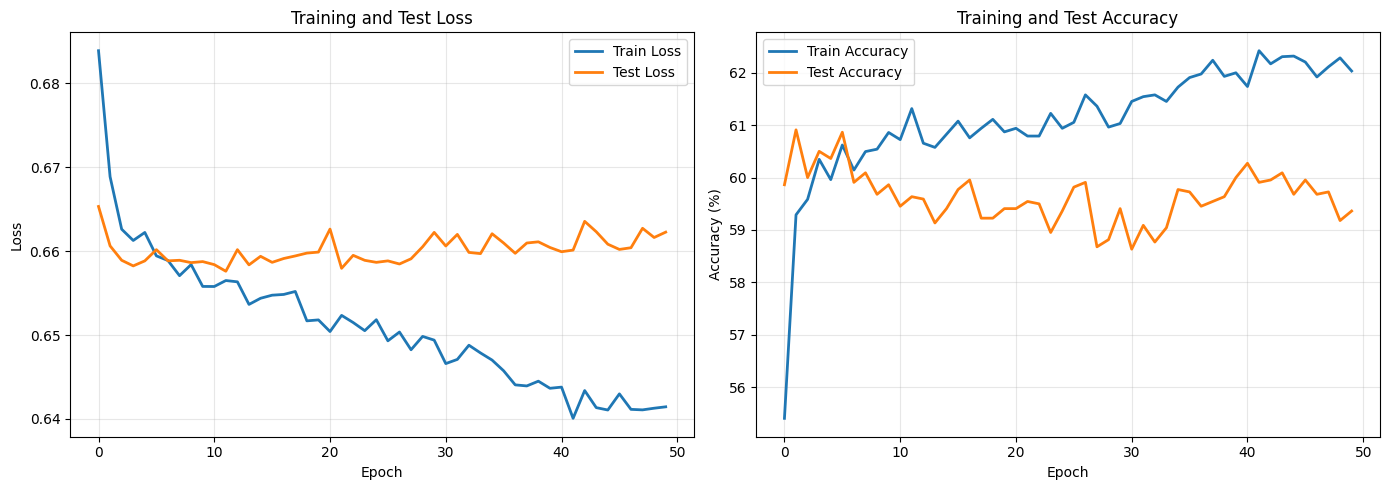

In [11]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
ax1.plot(train_losses, label='Train Loss', linewidth=2)
ax1.plot(test_losses, label='Test Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Test Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy curves
ax2.plot(train_accs, label='Train Accuracy', linewidth=2)
ax2.plot(test_accs, label='Test Accuracy', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Test Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

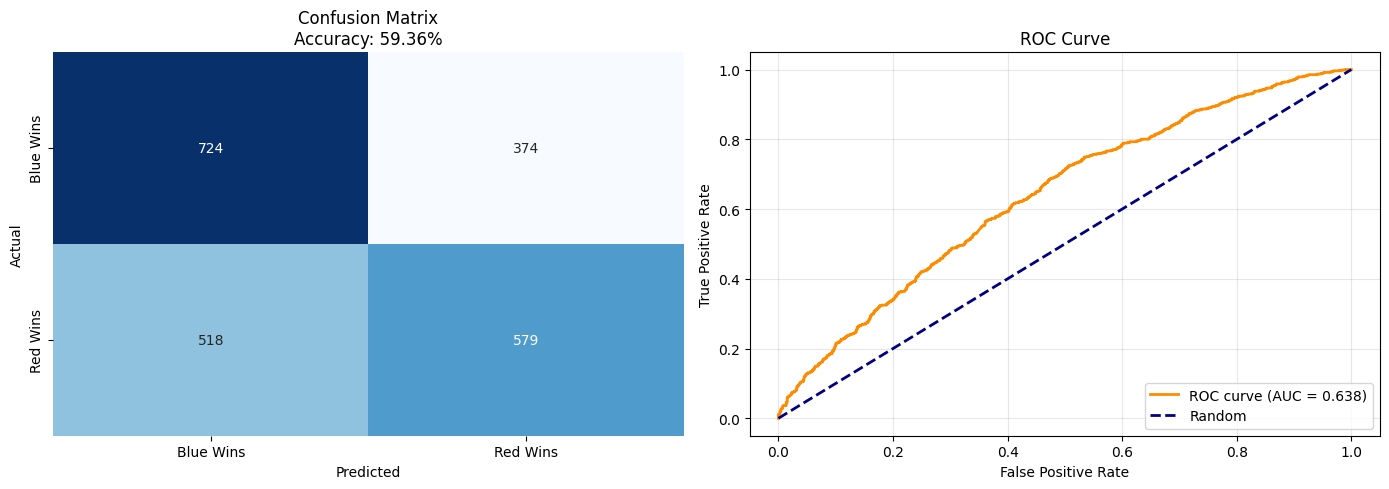


Classification Report:
              precision    recall  f1-score   support

   Blue Wins       0.58      0.66      0.62      1098
    Red Wins       0.61      0.53      0.56      1097

    accuracy                           0.59      2195
   macro avg       0.60      0.59      0.59      2195
weighted avg       0.60      0.59      0.59      2195



In [12]:
# Confusion matrix and classification report
model.eval()
with torch.no_grad():
    X_test_device = X_test_tensor.to(device)
    y_pred_proba = model(X_test_device).squeeze().cpu().numpy()
    y_pred = (y_pred_proba > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, cbar=False)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_title(f'Confusion Matrix\nAccuracy: {accuracy*100:.2f}%')
ax1.set_xticklabels(['Blue Wins', 'Red Wins'])
ax1.set_yticklabels(['Blue Wins', 'Red Wins'])

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')
ax2.legend(loc="lower right")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Blue Wins', 'Red Wins']))

In [13]:
# Save model, scaler, and feature names
save_dir = '../models'
os.makedirs(save_dir, exist_ok=True)

# Save PyTorch model
model_path = os.path.join(save_dir, 'ufc_predictor_pytorch.pth')
torch.save({
    'model_state_dict': model.state_dict(),
    'input_size': X_train.shape[1],
    'feature_names': X_train.columns.tolist(),
    'accuracy': accuracy,
    'epochs': epochs
}, model_path)

# Save scaler
import pickle
scaler_path = os.path.join(save_dir, 'scaler_pytorch.pkl')
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

print(f"Model saved to: {model_path}")
print(f"Scaler saved to: {scaler_path}")
print(f"Final accuracy: {accuracy*100:.2f}%")

Model saved to: ../models/ufc_predictor_pytorch.pth
Scaler saved to: ../models/scaler_pytorch.pkl
Final accuracy: 59.36%


# Custom Fight Prediction

In [14]:
# Get fighter stats from dataset
def get_fighter_stats(name, df):
    # Search in red corner
    red = df[df['RedFighter'].str.contains(name, case=False, na=False)]
    if len(red) > 0:
        f = red.iloc[0]
        return {
            'name': f['RedFighter'],
            'height': f['RedHeightCms'],
            'reach': f['RedReachCms'],
            'age': f['RedAge'],
            'wins': f['RedWins'],
            'losses': f['RedLosses'],
            'draws': f['RedDraws'],
            'win_streak': f['RedCurrentWinStreak'],
            'sig_str': f['RedAvgSigStrLanded'],
            'td': f['RedAvgTDLanded']
        }

    # Search in blue corner
    blue = df[df['BlueFighter'].str.contains(name, case=False, na=False)]
    if len(blue) > 0:
        f = blue.iloc[0]
        return {
            'name': f['BlueFighter'],
            'height': f['BlueHeightCms'],
            'reach': f['BlueReachCms'],
            'age': f['BlueAge'],
            'wins': f['BlueWins'],
            'losses': f['BlueLosses'],
            'draws': f['BlueDraws'],
            'win_streak': f['BlueCurrentWinStreak'],
            'sig_str': f['BlueAvgSigStrLanded'],
            'td': f['BlueAvgTDLanded']
        }
    return None

In [16]:
# Example: Predict a custom matchup (change fighter names here)
fighter1_name = "Islam Makhachev"
fighter2_name = "Charles Oliveira"

f1 = get_fighter_stats(fighter1_name, df)
f2 = get_fighter_stats(fighter2_name, df)

if f1 and f2:
    # Create features matching training data exactly
    red_fights = f1['wins'] + f1['losses'] + f1['draws']
    blue_fights = f2['wins'] + f2['losses'] + f2['draws']

    matchup = pd.DataFrame([{
        'height_diff': f1['height'] - f2['height'],
        'reach_diff': f1['reach'] - f2['reach'],
        'age_diff': f1['age'] - f2['age'],
        'wins_diff': f1['wins'] - f2['wins'],
        'losses_diff': f1['losses'] - f2['losses'],
        'win_rate_diff': (f1['wins'] / max(red_fights, 1)) - (f2['wins'] / max(blue_fights, 1)),
        'win_streak_diff': f1['win_streak'] - f2['win_streak'],
        'momentum_diff': f1['win_streak'] - f2['win_streak'],  # Simplified momentum
        'sig_str_landed_diff': f1['sig_str'] - f2['sig_str'],
        'sig_str_pct_diff': 0,  # Not available in simplified stats
        'td_landed_diff': f1['td'] - f2['td'],
        'td_pct_diff': 0,  # Not available
        'sub_att_diff': 0,  # Not available
        'ko_rate_diff': 0,  # Not available
        'sub_rate_diff': 0,  # Not available
        'experience_diff': red_fights - blue_fights,
        'total_rounds_diff': 0,  # Not available
        'title_bout': 0,  # Default to non-title
        'five_rounds': 0  # Default to 3 rounds
    }])

    # Scale and predict
    matchup_scaled = scaler.transform(matchup)
    matchup_tensor = torch.FloatTensor(matchup_scaled).to(device)

    model.eval()
    with torch.no_grad():
        prediction = model(matchup_tensor).item()

    # Display results
    print("=" * 60)
    print("FIGHT PREDICTION")
    print("=" * 60)
    print(f"\nFighter 1: {f1['name']} ({f1['wins']}-{f1['losses']})")
    print(f"  Win Probability: {prediction*100:.1f}%")
    print(f"\nFighter 2: {f2['name']} ({f2['wins']}-{f2['losses']})")
    print(f"  Win Probability: {(1-prediction)*100:.1f}%")
    print("\n" + "-" * 60)

    if prediction > 0.5:
        print(f"PREDICTED WINNER: {f1['name']}")
        conf = prediction
    else:
        print(f"PREDICTED WINNER: {f2['name']}")
        conf = 1 - prediction

    print(f"Confidence: {conf*100:.1f}%")

    if conf > 0.65:
        print("Assessment: High confidence")
    elif conf > 0.55:
        print("Assessment: Moderate confidence")
    else:
        print("Assessment: Close fight")
    print("=" * 60)
else:
    print("Fighter not found! Check the names.")

FIGHT PREDICTION

Fighter 1: Islam Makhachev (14-1)
  Win Probability: 95.1%

Fighter 2: Charles Oliveira (22-10)
  Win Probability: 4.9%

------------------------------------------------------------
PREDICTED WINNER: Islam Makhachev
Confidence: 95.1%
Assessment: High confidence
